# IT Diving | Machine Learning

Сегодня вам предстоит на практике познакомиться с основными задачами машинного обучения.
В ходе работы получится поработать с популярными библиотеками [`pandas`](https://pandas.pydata.org/), [`numpy`](https://numpy.org/), [`sklearn`](https://scikit-learn.org/stable/).

Для выполнения задания необходимо следовать по этой тетрадке сверху вниз и заполнять недостоющие части кода или отвечать на заданные вопросы.

In [1]:
# Импортируем необходимые библиотеки
# Полезно все импорты держать рядом

from os.path import exists

import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from PIL import Image
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

In [2]:
# Зафиксируем сид для генератора случайных чисел
# Это полезно для воспроизводимости результатов

RANDOM_SEED = 0xC0FFEE

# Классификация

Для знакомства с задачей классификацией воспользуемся выборкой данных о пациентах с доброкачественными и злокачественными опухолями. Наша задача — научиться их отличать.

Вместе с тетрадкой находится файл `cancer.csv` — это таблица, где каждая строчка соответствует отдельной клетке, а столбцы ее численные характеристики. Подробнее про датасет можно прочитать, например, вот [тут](
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data).

Начнем с чтения данных с диска, для этого реализуйте функцию `read_cancer_dataset`.
Поможет с этим библиотека `pandas` и пара полезных вещей из нее:
1. [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
2. [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)

In [3]:
def read_cancer_dataset(path_to_csv: str, shuffle: bool = True) -> pd.DataFrame:
    df = pd.read_csv(path_to_csv)

    if shuffle:
        df = pd.DataFrame(data=df)

    return df

In [4]:
# Посмотрим на наши данные:
# Колонка "label" отвечает за тип опухоли
# Колонки 1-30 отвечают за признаки

cancer_dataset = read_cancer_dataset("cancer.csv", shuffle=True)
cancer_dataset.head()

,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Первым делом необходимо подготовить данные к работе, а именно: разбить на тренировочную и тестовую части.

<u>Тренировочная часть</u> используется для обучения моделей, именно по ней ищутся необходимые зависимости в данных.

<u>Тестовая часть</u> используется для оценки качества моделей. Это данные, которые модель не видела, поэтому качество предсказаний по ним позволит оценить ее обобщающие способности.

Крайне важно, чтобы тестовая и тренировочная части описывали одинаковую природу данных. Например, в случае задачи классификации, важно чтобы соотношение классов было приблизительно равно в них. Иначе мы можем неправильно интерпретировать результаты.

Реализуйте функцию `prepare_cancer_dataset`, которая разделяет данные на таргет и признаки, а также выделяет тестовую часть. В этом может помочь [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) из библиотеки `sklearn`. Не забывайте фиксировать `random_state` или другие аналогичные параметры — это полезная привычка, которая съэкономить вам сотни часов дебага в будущем.

In [5]:
def prepare_cancer_dataset(
    dataset: pd.DataFrame, label_col_name: str = "label", test_size: float = 0.1
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    X = dataset.drop(label_col_name, axis=1)
    y = dataset[label_col_name].map({"B": 0, "M": 1}).values

    # Разделяем на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=1, stratify=y)

    return X_train, X_test, y_train, y_test

In [6]:
# Выполним подготовку данных
X_train, X_test, y_train, y_test = prepare_cancer_dataset(cancer_dataset)

# Код ниже проверяет правильность подготовки данных
# Если он упал, то надо исправить функцию выше
assert X_train.shape == (512, 30) and y_train.shape == (512,)
assert X_test.shape == (57, 30) and y_test.shape == (57,)

train_ratio = y_train.sum() / len(y_train)
test_ratio = y_test.sum() / len(y_test)
assert train_ratio < 0.5
assert np.abs((test_ratio - train_ratio) / train_ratio) < 0.015

Начнем с наивного решения — модель, которая предсказывает наиболее популярный класс.
Реализуйте методы `fit` и `predict` у класса ниже.

In [7]:
class MostCommonClassifier:
    def __init__(self):
        self.predict_class = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        unique_classes, class_counts = np.unique(y, return_counts=True)
        self.predict_class = unique_classes[np.argmax(class_counts)]

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.predict_class is None:
            raise RuntimeError("Call fit before predict")
        predictions = np.full(X.shape[0], self.predict_class)

        return predictions

"Обучим" наивную модель и оценим ее качество.

Для оценки качества воспользуемся двумя популярными метриками:
1. Точность (accuracy) измеряет, как часто модель предсказывает правильные ответы из всех возможных ответов. Она вычисляется как отношение числа правильных предсказаний к общему числу предсказаний. Например, если модель правильно предсказала 80 из 100 объектов, то точность будет равна 0.8 или 80%.

2. F1-score — более сложная метрика, она измеряет сбалансированность модели, учитывая как точность (precision), так и полноту (recall) предсказаний. Точнее говоря, она считает их гармоническое среднее. Использование такой метрики позволяет более точно оценить модели в случае сильной несбалансированности в данных.

Более подробно ознакомиться с метриками классификации можно, например, [тут](https://vk.com/@itresume-sobaka-ili-koshka-razbor-precision-recall-i-f1-score-i-drug).

In [8]:
def print_classification_report(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    print(f"Accuracy: {accuracy * 100:.2f}%", f"F1-score: {f1 * 100:.2f}%", sep="\n")

In [9]:
model_most_common = MostCommonClassifier()
model_most_common.fit(X_train, y_train)
y_pred_most_common = model_most_common.predict(X_test)
print_classification_report(y_test, y_pred_most_common)

Accuracy: 63.16%
F1-score: 0.00%


Во время лекции мы уже успели познакомиться с алгоритмом "K ближайших соседей".
Давайте воспользуемся им для решения нашей задачи.
Поможет в этом реализация из `sklearn`: [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [10]:
model_v1 = KNeighborsClassifier(n_jobs=-1)
model_v1.fit(X_train, y_train)
y_pred_v1 = model_v1.predict(X_test)

print_classification_report(y_test, y_pred_v1)

Accuracy: 94.74%
F1-score: 92.68%


Результат уже стал значительно выше! Если вы все сделали верно, то уже должны получить точность выше 90%.

Однако еще есть куда расти.
Один из главных способов поднять качество — это правильно настроить модель.

Ознакомьтесь с документацией алгоритма по ссылке выше и поиграйтесь с параметрами модели.
Например, вместо стандартного `n_neighbors=5` можно поставить `n_neighbors=7`.
Тогда при предсказании класса модель будет смотреть не на 5 ближайших соседей, а на 7.

Попробуйте получить как можно более высокое качество!

In [11]:
model_v2 = KNeighborsClassifier(n_neighbors=8, n_jobs=-1)
model_v2.fit(X_train, y_train)
y_pred_v2 = model_v2.predict(X_test)

print_classification_report(y_test, y_pred_v2)

Accuracy: 96.49%
F1-score: 95.00%


Одна из особенностей алгоритма "K ближайших соседей" — это необходимость вычислять расстояние между векторами признаков. По умолчанию используется обычное евклидово расстояние:

$$
\text{dist}(p, q) = \sqrt{\sum_{i=1}^n (p_i^2 - q_i^2)}
$$

Здесь $p$ и $q$ — это вектора размерности $n$, то есть массивы, описывающие $n$ признаков.

Из формулы можно заменить, что если значения одного из признаков очень большие, то он будет подавлять вклад признаков с маленькими значениями.

Давайте посмотрим на средние значения каждого признака в нашем датасете.

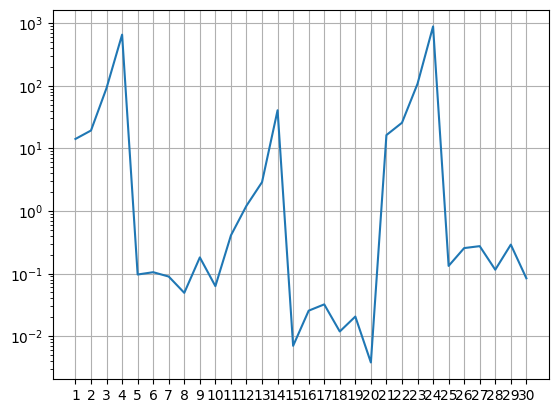

In [12]:
pyplot.grid(visible=True)
pyplot.yscale("log")
pyplot.plot(X_train.mean(axis=0))
pyplot.show()

Можно заметить, что некоторые признаки в среднем варьируются возле 1000, тогда как другие меньше 0.01.

Чтобы это исправить можно отмасштабировать признаки, а именно привести каждый признак к среднему 0 и дисперсии 1.
Помочь в этом может [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) из библиотеки `sklearn`.

Изучите документацию этого алгоритма и реализуйте функцию `scale_features`.

In [13]:
def scale_features(
    train_data: np.ndarray, test_data: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    
    scaler = StandardScaler()

    # Обучаем scaler на тренировочных данных
    scaler.fit(train_data)

    # Применяем масштабирование к тренировочным данным
    train_data_scaled = scaler.transform(train_data)

    # Применяем масштабирование к тестовым данным
    test_data_scaled = scaler.transform(test_data)

    return train_data_scaled, test_data_scaled

In [14]:
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

mean, std = X_train_scaled.mean(axis=0), X_train_scaled.std(axis=0)
assert np.allclose(mean, 0) and np.allclose(std, 1)

Обучите `KNeighborsClassifier` на новых данных, не забудьте подобрать оптимальные гиперпараметры.
Возможно достить точности выше 95%!

In [15]:
model_v3 = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
model_v3.fit(X_train_scaled, y_train)
y_pred_v3 = model_v3.predict(X_test_scaled)

print_classification_report(y_test, y_pred_v3)

Accuracy: 96.49%
F1-score: 95.00%


Задачу классификации можно решать множеством разных способов, многие из которых реализованы в библиотеки `sklearn`.

Вы можете ознакомиться со всем списком алгоритмов в библиотеке [здесь](https://scikit-learn.org/stable/supervised_learning.html). Не все они подходят для задачи классификации, ориентируйтесь на слово `Classifier` в названии, а также не стесняйтесь переходить по ссылкам и читать документацию и описание.

Попробуйте применить новые алгоритмы к нашей задаче. Рекомендуем обратить внимание на:
1. [`LogisticRegression`](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
2. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles)
3. [`SVC`](https://scikit-learn.org/stable/modules/svm.html#classification)

Для методов на основе линейных преобразований полезно использовать отмасштабированные данные.

Вполне реально получить идеальное качество в 100%!

# Регрессия

Для знакомства с задачей регрессии, нам поможет популярный датасет [Boston](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), он прикреплен к заданию в файле `boston.csv`.
Это набор данных с информаций о медианной стоимости домов, а также различных характеристик района.
Ознакомиться с датасетом можно по ссылке выше, а ниже представленно описание каждого столбца в данных:
```
1. crim      per capita crime rate by town
2. zn        proportion of residential land zoned for lots over 25,000 sq.ft.
3. indus     proportion of non-retail business acres per town
4. chas      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. nox       nitric oxides concentration (parts per 10 million)
6. rm        average number of rooms per dwelling
7. age       proportion of owner-occupied units built prior to 1940
8. dis       weighted distances to five Boston employment centres
9. rad       index of accessibility to radial highways
10. tax      full-value property-tax rate per \$10,000
11. ptratio  pupil-teacher ratio by town
12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. lstat    % lower status of the population
14. medv     median value of owner-occupied homes in \$'s
```

Наша задача — научится предсказывать стоимость дома по критериям района. То есть вместо ограниченного числа значений, модель теперь должна предсказывать любые целые числа.

Начнем с функции `read_boston_dataset`, которая считывает датасет с диска. В данных первые 14 строчек не относятся к данным, а описывают колонки, для их пропуска полезно использовать `skiprows` в функции `read_csv`.

# Регрессия

Для знакомства с задачей регрессии, нам поможет популярный датасет [Boston](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), он прикреплен к заданию в файле `boston.csv`.
Это набор данных с информаций о медианной стоимости домов, а также различных характеристик района.
Ознакомиться с датасетом можно по ссылке выше, а ниже представленно описание каждого столбца в данных:
```
1. crim      per capita crime rate by town
2. zn        proportion of residential land zoned for lots over 25,000 sq.ft.
3. indus     proportion of non-retail business acres per town
4. chas      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. nox       nitric oxides concentration (parts per 10 million)
6. rm        average number of rooms per dwelling
7. age       proportion of owner-occupied units built prior to 1940
8. dis       weighted distances to five Boston employment centres
9. rad       index of accessibility to radial highways
10. tax      full-value property-tax rate per \$10,000
11. ptratio  pupil-teacher ratio by town
12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. lstat    % lower status of the population
14. medv     median value of owner-occupied homes in \$'s
```

Наша задача — научится предсказывать стоимость дома по критериям района. То есть вместо ограниченного числа значений, модель теперь должна предсказывать любые целые числа.

Начнем с функции `read_boston_dataset`, которая считывает датасет с диска. В данных первые 14 строчек не относятся к данным, а описывают колонки, для их пропуска полезно использовать `skiprows` в функции `read_csv`.

In [16]:
def read_boston_dataset(path_to_csv: str, shuffle: bool = True) -> np.ndarray:
    df = pd.read_csv(path_to_csv, skiprows=14)
    if shuffle:
        df = pd.DataFrame(data=df)

    return df

In [17]:
boston_dataset = read_boston_dataset("boston.csv")
boston_dataset.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24000.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21600.0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34700.0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33400.0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36200.0


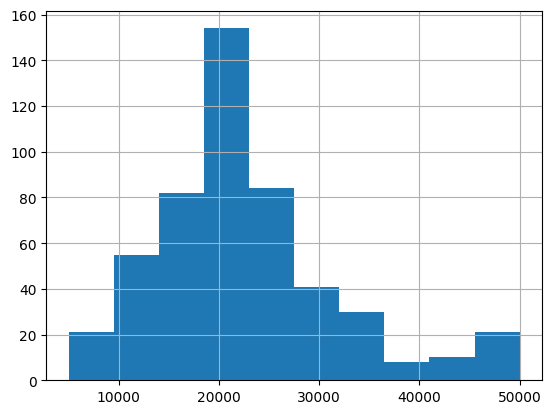

In [18]:
# Посмотрим на данные чуть ближе
# Оценим распределение цен в датасете

pyplot.hist(boston_dataset["medv"])
pyplot.grid(visible=True)
pyplot.show()

**Вопрос:** сделайте 2-3 вывода относительно цен.

1. Распределение цен на жилье в данном наборе данных является скошенным вправо. Это означает, что большая часть домов имеет относительно низкую стоимость, а небольшая часть домов стоит значительно дороже
2. Самые часто встречающиеся цены находятся в диапазоне от примерно 10 000 до 25 000$
3. Есть небольшое количество домов с очень высокой стоимостью (выше 50 000$)

По аналогии с задачей классификацией, необходимо выделить тренировочную и тестовую выборку.
Реализуйте для этого функцию `prepare_boston_dataset`

In [19]:
def prepare_boston_dataset(
    dataset: pd.DataFrame, label_col_name: str = "medv", test_size: float = 0.1
) -> tuple[np.ndarray, ...]:

    y = dataset[label_col_name].values

    X = dataset.drop(label_col_name, axis=1).values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test

In [20]:
X_train, X_test, y_train, y_test = prepare_boston_dataset(boston_dataset)

# Код ниже проверяет правильность подготовки данных
# Если он упал, то надо исправить функцию выше

assert X_train.shape == (455, 13) and y_train.shape == (455,)
assert X_test.shape == (51, 13) and y_test.shape == (51,)

Аналогично задаче классификации, начнем с наивного решения. Для задаче регрессии можно использовать, например, среднее значение по датасету. Однако вы можете предложить и свою оценку на основе анализа графика и вывода выше.

Реализуйте методы `fit` и `predict` у класса ниже.

In [21]:
class MeanRegression:
    def __init__(self):
        self.mean_value = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.mean_value = np.mean(y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.mean_value is None:
            raise RuntimeError("Call fit before predict")
        else:
            return np.full(X.shape[0], self.mean_value)

Обучим "наивную" модель и оценим ее качество.

В задаче регресии также существует большое множество метрик. Ознакомиться с ними можно, например, [тут](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0%D1%85_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8).

В нашем случае мы также будем использовать две метрики:
1. MSE (Mean Squared Error) — среднее квадратичное отклонение, интуитивно понятная метрика, но не всегда хорошо интерпретируется.

2. R2-score — "нормированная" MSE, не имеет границы снизу, 0 в случае предсказания среднего значения и 1 для идеальной работы.

In [22]:
def print_regression_report(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse:.2f}", f"R2-score: {r2:.2f}", sep="\n")

In [23]:
model_mean = MeanRegression()
model_mean.fit(X_train, y_train)
y_pred_mean = model_mean.predict(X_test)
print_regression_report(y_test, y_pred_mean)

MSE: 65008026.31
R2-score: -0.04


Получили низкое качество, поэтому перейдем к более серьезным моделям.

Одна из них — это линейная регрессия. Интутивно простая модель, но крайне выразительно и часто применяющаяся в различных вариациях и модификациях. Линейная регрессия предпологает линейную зависимость между признаками и таргетами и описывается следующей формулой:

$$
y = w_1 * x_1 + w_2 * x_2 + \dots + w_n + x_n + b = \sum_{i=1}^n w_i x_i + b
$$

Здесь $y$ — это таргет, $x_1, \dots x_n$ — признаки, а $w_1, \dots, w_n$ и $b$ — <u>параметры</u> модели.

В ходе тренировки модели эти параметры автоматически подбираются под обучающие данные.

Конечно, предполагать линейную зависимость между признаками и таргетом во многих случаях бывает невозможно. Для этого можно воспользоваться специальными ядрами, нелинейными преобразованиями, для обработки данных, созданием [полиномиальных признаков](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) или воспользоваться одной из [модификацией](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) уже реализованной в `sklearn`.

Обучим [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) из `sklearn`

In [24]:
model_v1 = LinearRegression(n_jobs=-1)
model_v1.fit(X_train, y_train)
y_pred_v1 = model_v1.predict(X_test)

print_regression_report(y_test, y_pred_v1)

MSE: 14995852.88
R2-score: 0.76


Качество модели значительно лучше.

Давайте проанализируем полученную модель, а именно посмотрим какие веса $w$ получились для каждого признака:

In [25]:
feature_names = boston_dataset.columns[:-1]
coefs = model_v1.coef_

for name, cf in sorted(zip(feature_names, coefs), key=lambda x: x[1], reverse=True):
    print(f"{name}\t{cf}")

rm	3755.791599863893
chas	2775.6516746486986
rad	311.8780226700274
zn	39.91346905947774
indus	21.293850352944375
b	10.328798226880856
age	4.570764240424957
tax	-11.81099032404405
crim	-119.8862619790868
lstat	-550.096256308326
ptratio	-947.5563368893572
dis	-1470.6459495440813
nox	-18585.49595695305


**Вопрос:** как можно интерпретировать полученный список?

**Ответ:** список показывает самые важные для модели факторы по убыванию, например:
rm - это среднее число комнат в доме, имеет самый большой коэффициент. Он означает, чем больше комнат, тем дороже дом.
chas имеет второй по величине положительный коэффициент. Это означает, что дома рядом с рекой стОят дороже.
rad имеет 3ий по величине положительный коэффициент. Чем лучше ближе дом к дороге, тем дороже он стОит.

Внутри `sklearn` есть множество алгоритмов регрессии, попробуйте применить их для этой задачи.

Например, можно взглянуть на [`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html), довольно мощный алгоритм, но требующий детальной настройки.

В этой задаче можно получить R2-score больше 0.9, удачи!

# Кластеризация

Последний блок нашей практики посвящен задаче кластеризации, задаче где отсутствуют таргеты и необходимо уметь группировать данные в осмысленные блоки. Примерами задачи кластеризации может служить разбиение новостей по разным темам или выявление пользователей в соц. сетях с общими интересами.

Мы применим кластеризацию к картинкам, что может быть полезно, если необходимо ее сжать.

Выберите любую картинку, может быть любимый шаблон мема или чья-то фотография. Пример подходящей картинки прикреплен к практике, в файле `image.jpg`. 

In [26]:
def read_image(image_path: str) -> np.ndarray:
    with Image.open(image_path) as img:
        data = np.array(img)
    return data


def show_image(image: np.ndarray) -> np.ndarray:
    pyplot.axis("off")
    pyplot.tight_layout()
    pyplot.imshow(image)
    pyplot.show()

In [27]:
# Разместите картинку рядом с тетрадкой
# И укажите ее название в переменной ниже

IMAGE_NAME = "image.jpg"

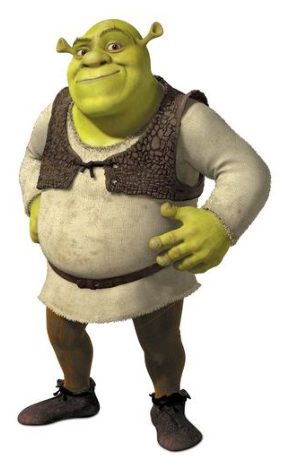

In [28]:
image = read_image(IMAGE_NAME)
height, width = image.shape[:2]

show_image(image)

Картинка в памяти хранится как трехмерный массив `[h; w; 3]`, однако алгоритмы кластеризации требуют от нас двумерный массив `[n_samples; n_features]`. В случае картинок, `n_features` — 3, RGB код цвета каждого пикселя, а `n_samples` общее число пикселей.

Реализуйте функцию `preprocess_image`, которая получает картинку и возвращает нужный двумерный массив.

In [29]:
def preprocess_image(image: np.ndarray) -> np.ndarray:
    height, width, _ = image.shape
    n_pixels = height * width
    return image.reshape(n_pixels, 3)

In [30]:
X_train = preprocess_image(image)

assert X_train.shape == (height * width, 3)

В качестве первого алгоритма возьмем [`KMeans`](https://scikit-learn.org/stable/modules/clustering.html#k-means). Его идея близка к алгоритму классификации "K ближайших соседей", считаются попарные расстояния между точками и наиболее близкие объединяются в кластеры

In [31]:
k_means = KMeans(n_clusters=5, n_init=1, random_state=RANDOM_SEED)
k_means.fit(X_train)

KMeans(n_clusters=5, n_init=1, random_state=12648430)

Заменим каждый цвет на картинке на средний цвет кластера, куда попал соответствующий кластер.

Для этого реализуйте функцию `replace_to_centroid`, которая принимает полученные индексы кластеров и цвета кластеров и возвращает цвета для каждой точки.

In [32]:
def replace_to_centroid(
    predicted_cluster: np.ndarray, centroids: np.ndarray
) -> np.ndarray:
    
    n_samples = predicted_cluster.shape[0]
    colors = np.zeros((n_samples, 3), dtype=np.int32)

    for i in range(n_samples):
        cluster_index = predicted_cluster[i]
        colors[i] = centroids[cluster_index]

    return colors

In [33]:
predicted_clusters = k_means.predict(X_train)
X_predicted = replace_to_centroid(predicted_clusters, k_means.cluster_centers_)

assert X_predicted.shape == X_train.shape

Приведем матрицу обратно к формату картинки и посмотрим, что получилось!

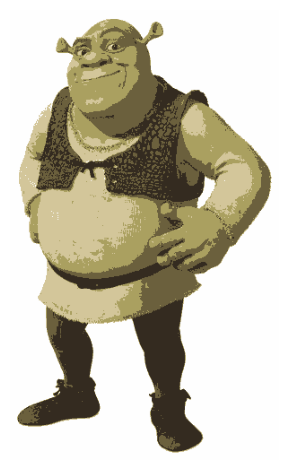

In [34]:
new_image = X_predicted.reshape(height, width, 3).astype(np.int32)
show_image(new_image)

Изучите другие алгоритмы кластеризации, доступные в `sklearn`: [алгоритмы](https://scikit-learn.org/stable/modules/clustering.html).

Для применения к нашей задаче, необходимо выбрать такой, где задается число кластеров, обычно параметр называется `n_clusters`. Помните, что задача кластеризации трудная с вычислительной точки зрения, домашний ПК не всегда может с ней справиться.

Поэкспериментируйте с другими алгоритмами и сравните, как они ведут себя относительно `KMeans` для задачи сжатия изображений.

# Дополнительное задание

# Классификация

Для задачи классификации я решил использовать алгоритм RandomForestClassifier

In [35]:
data = pd.read_csv('cancer.csv')

X = data.drop('label', axis=1)
y = data['label'].map({'B': 0, 'M': 1})

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
y_pred = model.predict(X_test)

In [39]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")

Accuracy: 96.49%
F1-score: 95.24%


RandomTreeClassifier показал себя почти также, как и KNeighbors, обычная точность совпала, а F1 в RandomTreeClassifier выше на .24%

# Регрессия

Для задачи регрессии я выбрал GradientBoostingRegressor

In [40]:
boston_data = pd.read_csv("boston.csv", skiprows=14)

In [41]:
X = boston_data.drop("medv", axis=1)
y = boston_data["medv"]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [43]:
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)

y_pred = gb_regressor.predict(X_test)

In [44]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [45]:
print(f"MSE: {mse:.2f}")
print(f"R2-score: {r2:.2f}")

MSE: 5308384.04
R2-score: 0.91


Градиентный бустинг показал себя в данной задаче намного лучше линейной регрессии, показав R2 score 0.91, когда линейная регрессия показала 0.76

# Кластеризация

Для задачи сжатия изображения я выбрал алгоритм Mini-Batch KMeans

In [46]:
def read_image(image_path: str) -> np.ndarray:
    with Image.open(image_path) as img:
        data = np.array(img)
    return data

def show_image(image: np.ndarray) -> None:
    plt.axis("off")
    plt.tight_layout()
    plt.imshow(image)
    plt.show()

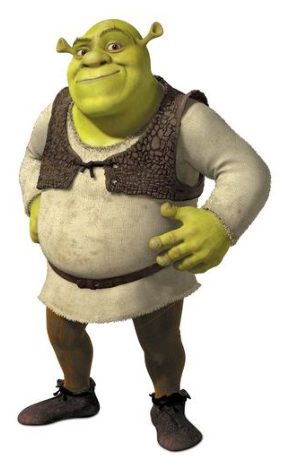

In [47]:
IMAGE_NAME = "image.jpg"
image = read_image(IMAGE_NAME)
height, width = image.shape[:2]
show_image(image)

In [48]:
def preprocess_image(image: np.ndarray) -> np.ndarray:
    height, width, _ = image.shape
    n_pixels = height * width
    return image.reshape(n_pixels, 3)

In [49]:
X_train = preprocess_image(image)

assert X_train.shape == (height * width, 3)

In [50]:
n_clusters = 5
batch_size = 1000
mini_batch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=RANDOM_SEED)
mini_batch_kmeans.fit(X_train)

MiniBatchKMeans(batch_size=1000, n_clusters=5, random_state=12648430)

In [51]:
def replace_to_centroid(predicted_cluster: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    n_samples = predicted_cluster.shape[0]
    colors = np.zeros((n_samples, 3), dtype=np.int32)

    for i in range(n_samples):
        cluster_index = predicted_cluster[i]
        colors[i] = centroids[cluster_index]

    return colors

In [52]:
predicted_clusters = mini_batch_kmeans.predict(X_train)
X_predicted = replace_to_centroid(predicted_clusters, mini_batch_kmeans.cluster_centers_)

assert X_predicted.shape == X_train.shape

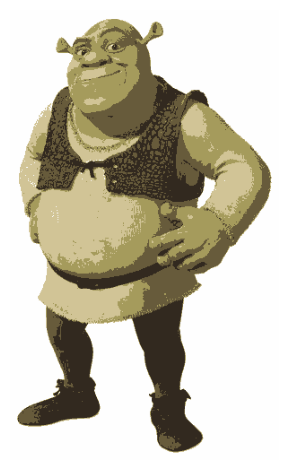

In [53]:
new_image = X_predicted.reshape(height, width, 3).astype(np.int32)
show_image(new_image)

## Сравнение ##

На маленьком наборе данных эти два алгоритма почти не отличаются, но если сравнивать эти два алгоритма на бОльших датасетах, то во многом minibatch k-means превосходит обычный k-means:
В эффективности mini-batch показывает себя лучше, т.к. он разбивает данные на части.
В использовании памяти k-means требует весь обьем памяти, а мини-батч использует только часть данных на каждой итерации
Также мини-батч в среднем сходится быстрее из-за разбиения данных на части
Мини-батч более масштабируем и эффективен для больших датасетов, а обычный k-means становится медленным и требовательным к памяти